# Project Description:

The purpose of this project is to implement a neural network that performs the translation of mathematical formulae from traditional **infix notation**—where the operator appears between two operands—to **postfix** (also known as Reverse Polish Notation), where the operator follows the operands.

Infix notation is the most commonly used in human-readable mathematics (e.g., a + b), but it is inherently ambiguous without additional syntactic aids such as parentheses or operator precedence rules. This ambiguity arises because different parse trees can correspond to the same expression depending on how operations are grouped.

In contrast, postfix notation eliminates the need for parentheses entirely. The order of operations is explicitly encoded by the position of the operators relative to the operands, making it more suitable for stack-based evaluation and easier to parse programmatically.

**Example:**

Consider the ambiguous infix expression:
a + b * c

This expression can be parsed in at least two different ways:

Interpretation (Infix):	(a + b) * c	   
Equivalent Postfix: ab+c*

Interpretation (Infix):	a + (b * c)	          
Equivalent Postfix: abc*+


This project aims to learn such disambiguations and generate the correct postfix form from a given infix expression using a data-driven approach based on neural networks. To simplify the task and control the complexity of expressions, we restrict our dataset to formulae with a maximum syntactic depth of 3. This means that the abstract syntax trees representing these expressions will have at most three levels, ensuring that the neural network operates on a bounded and manageable set of possible structures.

# Import

In [39]:
import os
print(os.environ.get('TF_ENABLE_ONEDNN_OPTS'), os.environ.get('TF_CPP_MIN_LOG_LEVEL'))

import random
from collections import defaultdict
import numpy as np
import tensorflow as tf

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense, AdditiveAttention, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import string
import matplotlib.pyplot as plt

0 3


We build formulae using 5 identifiers a,b,c,d,e and 4 binary operators +,-,*,/.
For simplicity we do not take advantage of precedence or associativity rules for infix notation, and suppose that all binary operations as always fully parenthesizes: (e1 op e2).

In [40]:
# -------------------- Constants --------------------
OPERATORS = ['+', '-', '*', '/']
IDENTIFIERS = list('abcde')
SPECIAL_TOKENS = ['PAD', 'SOS', 'EOS']
SYMBOLS = ['(', ')', '+', '-', '*', '/']
VOCAB = SPECIAL_TOKENS + SYMBOLS + IDENTIFIERS + ['JUNK'] #may use junk in autoregressive generation

token_to_id = {tok: i for i, tok in enumerate(VOCAB)}
id_to_token = {i: tok for tok, i in token_to_id.items()}
VOCAB_SIZE = len(VOCAB)
PAD_ID = token_to_id['PAD']
EOS_ID = token_to_id['EOS']
SOS_ID = token_to_id['SOS']

MAX_DEPTH = 3
MAX_LEN = 4*2**MAX_DEPTH -2 #enough to fit expressions at given depth (+ EOS)

In [41]:
# -------------------- Expression Generation --------------------
def generate_infix_expression(max_depth):
    if max_depth == 0:
        return random.choice(IDENTIFIERS)
    elif random.random() < 0.5:
        return generate_infix_expression(max_depth - 1)
    else:
        left = generate_infix_expression(max_depth - 1)
        right = generate_infix_expression(max_depth - 1)
        op = random.choice(OPERATORS)
        return f'({left} {op} {right})'

def tokenize(expr):
    return [c for c in expr if c in token_to_id]

def infix_to_postfix(tokens):
    precedence = {'+': 1, '-': 1, '*': 2, '/': 2}
    output, stack = [], []
    for token in tokens:
        if token in IDENTIFIERS:
            output.append(token)
        elif token in OPERATORS:
            while stack and stack[-1] in OPERATORS and precedence[stack[-1]] >= precedence[token]:
                output.append(stack.pop())
            stack.append(token)
        elif token == '(':
            stack.append(token)
        elif token == ')':
            while stack and stack[-1] != '(':
                output.append(stack.pop())
            stack.pop()
    while stack:
        output.append(stack.pop())
    return output

def encode(tokens, max_len=MAX_LEN):
    ids = [token_to_id[t] for t in tokens] + [EOS_ID]
    return ids + [PAD_ID] * (max_len - len(ids))

def decode_sequence(token_ids, id_to_token, pad_token='PAD', eos_token='EOS'):
    """
    Converts a list of token IDs into a readable string by decoding tokens.
    Stops at the first EOS token if present, and ignores PAD tokens.
    """
    tokens = []
    for token_id in token_ids:
        token = id_to_token.get(token_id, '?')
        if token == eos_token:
            break
        if token != pad_token:
            tokens.append(token)
    return ' '.join(tokens)

def generate_dataset(n,max_depth=MAX_DEPTH):
    X, Y = [], []
    for _ in range(n):
        expr = generate_infix_expression(MAX_DEPTH)
        #expr = expr_gen.generate(max_depth=max_dthep)
        infix = tokenize(expr)
        postfix = infix_to_postfix(infix)
        X.append(encode(infix))
        Y.append(encode(postfix))
    return np.array(X), np.array(Y)

#you might use the shift function for teacher-forcing
def shift_right(seqs):
    shifted = np.zeros_like(seqs)
    shifted[:, 1:] = seqs[:, :-1]
    shifted[:, 0] = SOS_ID
    return shifted

In [42]:
# Let us define a simple dataset, and inspect a few samples.
X_train, Y_train = generate_dataset(10)
decoder_input_train = shift_right(Y_train)

# Dataset
X_val, Y_val = generate_dataset(10)
decoder_input_val = shift_right(Y_val)
i =  np.random.randint(10)
print(i)
print("infix : ",decode_sequence(X_train[i],id_to_token))
print("posfix notation: ",decode_sequence(Y_train[i],id_to_token))
print("teacher forcing : ", decode_sequence(decoder_input_train[i],id_to_token))

6
infix :  ( ( ( c * a ) - d ) / ( ( c + b ) * ( e / b ) ) )
posfix notation:  c a * d - c b + e b / * /
teacher forcing :  SOS c a * d - c b + e b / * /


# Constraints
* You may use any architecture (decoder-only, encoder-decoder, or other).

* The maximum number of parameters is 2 million.

* Beam search is not allowed.

* You may adapt the formula generator to your needs, but preserve its core logic—especially the frequency distribution of formulas by depth, as it may significantly influence model performance.

* You may train your model using a pre-generated fixed dataset (e.g., an array) or directly use an on-the-fly generator.




# Evaluation

We shall evaluate a generated item y_pred using "prefix accuracy", the lenght of
the initial prefix of y_pred matching the ground true y_true. This will be divided by the maximum length of y_true and y_pred (up to EOS), so that a perfect match has score 1.

* It's more informative than exact match (which is often 0)

* It’s tighter than edit distance: focuses on generation flow

* Captures where the model starts to make errors



In [43]:
def prefix_accuracy_single(y_true, y_pred, id_to_token, eos_id=EOS_ID, verbose=False):
    t_str = decode_sequence(y_true, id_to_token).split(' EOS')[0]
    p_str = decode_sequence(y_pred, id_to_token).split(' EOS')[0]
    t_tokens = t_str.strip().split()
    p_tokens = p_str.strip().split()
    max_len = max(len(t_tokens), len(p_tokens))

    match_len = sum(x == y for x, y in zip(t_tokens, p_tokens))
    score = match_len / max_len if max_len>0 else 0

    if verbose:
        print("TARGET :", ' '.join(t_tokens))
        print("PREDICT:", ' '.join(p_tokens))
        print(f"PREFIX MATCH: {match_len}/{len(t_tokens)} → {score:.2f}")

    return score

For the exam, evaluate you model on a test set of 20 expressions. Repeat this evaluation 10 times, and return the mean and std for this rounds.

Be sure to evalutate the generator: your model may only take as input the expression in infix format and return its translation to postifix.

If you are usuing an encoder-decoder model, generation must be done autoregressively.

# What to deliver

As usual you are supposed to deliver a single notebook witten in Keras. You are auhtorized to use Keras3 with pytorch as backend if your prefer.

Do no upload a zip file: the submission will be rejected.

The python notebook should have a clear documentation of the training phase, possibly with its history.

You should be able to provide the network paramters upon request. Even better, consider a way to upload them inside your notebook using gdown.

---

# DL Project start 

Leonardo Billi 0001189587

06/25

## Seed

In [ ]:
import json
from IPython import get_ipython
ip = get_ipython()

def generate_report(hparams: dict, outputs: dict, figures: dict, output_path="progettoDL/report/report.md", title = " "): #, metrics: dict
    """
    Genera automaticamente un report Markdown includendo:
    - Iperparametri (hparams)
    - Metriche di training/validation (metrics: dict di liste per epoca)
    - Figure (dict nome->matplotlib.Figure)
    """
    # Salva le figure su file
    for name, fig in figures.items():
        filename = f"progettoDL/report/img/{name}.png"
        fig.savefig(filename, bbox_inches='tight')
    
    # Scrive il report.md
    with open(output_path, 'a') as f:
        f.write("\n\n---\n\n")
        f.write(f"# {title}\n\n")
        
        # Iperparametri
        f.write("## Iperparametri\n")
        for key, value in hparams.items():
            f.write(f"- **{key}**: {value}\n")
        f.write("\n")
        
        f.write("## Output di celle\n")
        for name, out in outputs.items():
            f.write(f"### {name}\n")
            f.write("```\n")
            f.write(out)
            if not out.endswith("\n"):
                f.write("\n")
            f.write("```\n\n")
        
        # # Metriche
        # f.write("## Metriche per epoca\n")
        # f.write("| Epoca | " + " | ".join(metrics.keys()) + " |\n")
        # f.write("|---" * (len(metrics) + 1) + "|\n")
        # num_epochs = len(next(iter(metrics.values())))
        # for i in range(num_epochs):
        #     row = [str(i+1)]
        #     for metric in metrics.values():
        #         row.append(f"{metric[i]:.4f}")
        #     f.write("| " + " | ".join(row) + " |\n")
        # f.write("\n")
        
        # Figure
        f.write("## Figure\n")
        for name in figures.keys():
            f.write(f"### {name}\n")
            f.write(f"![{name}](img/{name}.png)\n\n")


In [45]:
def set_global_seed(seed=42):
    print(f"global seed = {seed}.")

    # Seed Python
    random.seed(seed)

    # Seed NumPy
    np.random.seed(seed)

    # Seed TensorFlow
    tf.keras.utils.set_random_seed(seed)
    tf.random.set_seed(seed)

    # Set determinism for TensorFlow
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 

SEED = 42
set_global_seed(SEED)

global seed = 42.


## MODEL

Durante l'analisi del task, dopo aver fatto qualche ricerca pensavo di implementare o una RNN oppure un transformer.  
Dopo la visione dei seguenti link e anche altri collegati ad essi, ho scelto di usare un **encoder–decoder RNN con attention**.
[1]: https://machinelearningmastery.com/define-encoder-decoder-sequence-sequence-model-neural-machine-translation-keras "How to Develop a Seq2Seq Model for Neural Machine Translation in Keras - MachineLearningMastery.com"  
[2]: https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras "How to Develop an Encoder-Decoder Model with Attention in Keras - MachineLearningMastery.com"  
Ho reputato che sia una archiettetura migliore visto la natura dei due modelli.  

* **RNN + Attention**: la LSTM processa i token **uno alla volta**, mantenendo uno stato ricorrente $h_t$ che codifica esattamente la storia di tutti i token precedenti. Il meccanismo di attention poi “pesca” da questa storia solo i punti rilevanti (parentesi, operatori, identificatori) ogni volta che serve generare un nuovo token. Questo modello è “nativamente sequenziale” e ben tarato per dati in cui l’ordine e il raggruppamento sono fondamentali (come le parentesi) .

* **Transformer**: basata prioncipalmente su **self-attention** sui token della stessa sequenza, abbinata a Positional Encoding per inserire nozione di ordine. Questo è ottimo per sequenze molto lunghe o con dipendenze a lungo raggio (come paragrafi di testo), ma per lunghezze modeste (\~30 token) e con strutture ad albero già esplicitate dalle parentesi, l’overhead di gestire Positional Encoding e multi‐head self‐attention non mi sembreava portare un reale vantaggio. Anzi, introduce complessità aggiuntiva di maschere e normalizzazioni.

In sintesi, il mio modello funziona così:

1. **Encoder** – un singolo LSTM unidirezionale (`enc_units`, return\_sequences=True) che legge la sequenza di token infissi (lunghezza fissa `max_len`) trasformati tramite un **Embedding** di dimensione `embed_dim`. L’LSTM restituisce:

   * la serie completa di hidden states `enc_outputs` (shape `[batch, max_len, enc_units]`),
   * lo stato finale `state_h`, `state_c` (per inizializzare il decoder).

2. **Decoder + Attention** 
   - *Decoder* – un altro LSTM unidirezionale di pari capacità (`dec_units`), che riceve in input la sequenza di token “shiftati” per il *teacher forcing* (`dec_inputs = [SOS] + y_true[:-1]`). Inizializzo il suo stato nascosto con `state_h, state_c` provenienti dall’encoder.  
   
   - *Attention* – applico un meccanismo di **Additive (Bahdanau) Attention** sui due tensori `[dec_outputs, enc_outputs]` per calcolare, a ogni passo del decoder, un context vector che enfatizza i token dell’infix più rilevanti per la produzione corrente. Concateno questo vettore a `dec_outputs` e lo proietto via `Dense(vocab_size, softmax)` per ottenere la distribuzione di probabilità sul prossimo token.
      $$
            e_{t,i} = v^\top \tanh\bigl(W_q\,h_t + W_k\,H_i\bigr)
      $$



In [46]:
def create_encoder_model(vocab_size, embed_dim, enc_units, max_len):
    enc_inputs = Input(shape=(max_len,), name="enc_inputs")
    x = Embedding(input_dim=vocab_size,
                  output_dim=embed_dim,
                  mask_zero=False,
                  name="enc_embedding")(enc_inputs)
    enc_outputs, state_h, state_c = LSTM(enc_units,
                                        # dropout=0.2,            # 20% di dropout sull’input xₜ
                                        # recurrent_dropout=0.2,  # 20% di dropout su hₜ₋₁
                                        return_sequences=True,
                                        return_state=True,
                                        name="encoder_lstm")(x)
    return Model(enc_inputs, [enc_outputs, state_h, state_c], name="encoder_model")

In [47]:
def create_decoder_model(vocab_size, embed_dim, dec_units, max_len, enc_units):
    # Inputs
    dec_inputs   = Input(shape=(max_len,), name="dec_inputs")     # teacher-forcing
    enc_outputs  = Input(shape=(max_len, enc_units), name="enc_outs")
    state_h_in   = Input(shape=(dec_units,), name="h_in")
    state_c_in   = Input(shape=(dec_units,), name="c_in")

    # Embedding + LSTM
    x  = Embedding(input_dim=vocab_size,
                   output_dim=embed_dim,
                   mask_zero=False,
                   name="dec_embedding")(dec_inputs)
    dec_outputs, state_h_out, state_c_out = LSTM(dec_units,
                                                # dropout=0.2,            # 20% di dropout sull’input xₜ
                                                # recurrent_dropout=0.2,  # 20% di dropout su hₜ₋₁
                                                return_sequences=True,
                                                return_state=True,
                                                name="decoder_lstm")(
        x, initial_state=[state_h_in, state_c_in]
    )

    # Attention
    context = AdditiveAttention(name="attention")(
        [dec_outputs, enc_outputs]
    )
    concat = Concatenate(axis=-1, name="concat")([dec_outputs, context])

    # Projection
    logits = Dense(vocab_size, activation="softmax", name="vocab_dist")(concat)

    return Model(
        [dec_inputs, enc_outputs, state_h_in, state_c_in],
        [logits, state_h_out, state_c_out],
        name="decoder_model"
    )


In [48]:
def create_seq2seq_model(encoder, decoder, max_len):
    # encoder.input is the encoder_inputs, decoder.input[0] is decoder_inputs
    enc_in = encoder.input                                # (batch, max_len)
    dec_in = decoder.input[0]                             # (batch, max_len)
    
    # 1. forward through encoder
    enc_outs, h, c = encoder(enc_in)
    
    # 2. forward through decoder (teacher forcing)
    logits, _, _ = decoder([dec_in, enc_outs, h, c])
    
    # full model
    return Model([enc_in, dec_in], logits, name="seq2seq_model")

Since vocab size is small and each token does not have so much possible different meaning, we can use a small embedding dimension. (16/32)  


In [49]:
EMBED_DIM  = 32
ENC_UNITS = 256
DEC_UNITS = 256

encoder = create_encoder_model(VOCAB_SIZE, EMBED_DIM, ENC_UNITS, MAX_LEN)
decoder = create_decoder_model(VOCAB_SIZE, EMBED_DIM, DEC_UNITS, MAX_LEN, ENC_UNITS)
seq2seq = create_seq2seq_model(encoder, decoder, MAX_LEN)

encoder.summary()
decoder.summary()
seq2seq.summary()

Model: "encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ enc_inputs (InputLayer)         │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_embedding (Embedding)       │ (None, 30, 32)         │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_lstm (LSTM)             │ [(None, 30, 256),      │       295,936 │
│                                 │ (None, 256), (None,    │               │
│                                 │ 256)]                  │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,416 (1.13 MB)

 Trainable params: 296,416 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ dec_inputs          │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_embedding       │ (None, 30, 32)    │        480 │ dec_inputs[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ h_in (InputLayer)   │ (None, 256)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c_in (InputLayer)   │ (None, 256)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 30, 256), │    295,936 │ dec_embedding[0]… │
│                     │ (None, 256),      │            │ h_in[0][0],       │
│                     │ (None, 256)]      │            │ c_in[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_outs            │ (None, 30, 256)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 30, 256)   │        256 │ decoder_lstm[0][… │
│ (AdditiveAttention) │                   │            │ enc_outs[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 30, 512)   │          0 │ decoder_lstm[0][… │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vocab_dist (Dense)  │ (None, 30, 15)    │      7,695 │ concat[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 304,367 (1.16 MB)

 Trainable params: 304,367 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Model: "seq2seq_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ enc_inputs          │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_inputs          │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_model       │ [(None, 30, 256), │    296,416 │ enc_inputs[0][0]  │
│ (Functional)        │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_model       │ [(None, 30, 15),  │    304,367 │ dec_inputs[0][0], │
│ (Functional)        │ (None, 256),      │            │ encoder_model[0]… │
│                     │ (None, 256)]      │            │ encoder_model[0]… │
│                     │                   │            │ encoder_model[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 600,783 (2.29 MB)

 Trainable params: 600,783 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

## Dataset

### Methods

In [50]:
# Same as generate_dataset but returns also the expression
def generate_dataset_express(n,max_depth=MAX_DEPTH):
    X, Y, Expr = [], [], []
    for _ in range(n):
        expr = generate_infix_expression(MAX_DEPTH)
        infix = tokenize(expr)
        postfix = infix_to_postfix(infix)
        X.append(encode(infix))
        Y.append(encode(postfix))
        Expr.append(expr)
    return np.array(X), np.array(Y), Expr

def generate_unique_dataset_express(n, exclude_set, max_depth=MAX_DEPTH):
    """
    Used to generate validation set val_b
    """
    Xs, Ys, exprs = [], [], []
    while len(exprs) < n:
        # generate single expression
        e = generate_infix_expression(max_depth)         
        if e in exclude_set:
            continue
        # if not converted to postfix
        tokens_in = tokenize(e)
        tokens_out = infix_to_postfix(tokens_in)
        Xs.append(encode(tokens_in))
        Ys.append(encode(tokens_out))
        exprs.append(e)
        exclude_set.append(e)  # avoid repetition
    return np.array(Xs), np.array(Ys), exprs


def analize_dataset(data, max_depth=MAX_DEPTH):

    idx_map = defaultdict(list)
    for idx, key in enumerate(data):
        idx_map[key].append(idx)    #for each string in data, keep track of all its indices
    counts = {key: len(idxs) for key, idxs in idx_map.items() if len(idxs) > 1} #for each duplicate string in data, keep track of hpw many duplicates there are
    duplicates = {key: idxs for key, idxs in idx_map.items() if len(idxs) > 1} #for each duplicate string in data, keep track of all its indices
    total = sum(counts.values()) 

    print(f"Found {len(duplicates)} duplicate string with totla counts: {total}")
    print(f"the percentage of duplicates is: {total / len(data) * 100}%")
    print("the top 10 duplicates are:")
    for key, idxs in sorted(counts.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {key} = {idxs}")

    return duplicates, counts


### Dataset analysis

In [51]:
sizes = [20, 1_000, 5_000, 10_000, 100_000]
for size in sizes:
    print(f"Generating dataset of size {size}...")
    _, _, Expr = generate_dataset_express(size)
    duplicates, _ = analize_dataset(Expr)
    print(f"Dataset of size {size} generated with {len(duplicates)} duplicates.")
    print("-" * 50)

Generating dataset of size 20...
Found 0 duplicate string with totla counts: 0
the percentage of duplicates is: 0.0%
the top 10 duplicates are:
Dataset of size 20 generated with 0 duplicates.
--------------------------------------------------
Generating dataset of size 1000...
Found 77 duplicate string with totla counts: 323
the percentage of duplicates is: 32.300000000000004%
the top 10 duplicates are:
  c = 30
  e = 24
  d = 23
  a = 19
  b = 16
  (e - d) = 7
  (c - a) = 6
  (a - c) = 6
  (d - e) = 6
  (e - c) = 6
Dataset of size 1000 generated with 77 duplicates.
--------------------------------------------------
Generating dataset of size 5000...
Found 240 duplicate string with totla counts: 2021
the percentage of duplicates is: 40.42%
the top 10 duplicates are:
  d = 136
  b = 125
  e = 121
  c = 111
  a = 100
  (d + a) = 20
  (b / a) = 18
  (e * b) = 18
  (a * e) = 18
  (e - e) = 17
Dataset of size 5000 generated with 240 duplicates.
----------------------------------------------


In genere vige la regola "piu' dati si hanno meglio e'".  
In questo caso, pero', poiche' vogliamo che il modello impari le regole di traduzione, e quindi non di riconoscere la stringa in input e legarlo ad un output, ho scelto un dataset "statico" da 10_000 sample (mi sebra un buon bilancaimento tra presenza di duplicati e non).  
Per la natura del task e per com'e' definita la produzione di dati produrre un dataset da 10_000 o fare un the fly 10_000 volte statisticamente riportera' la stessa distribuzzione di dati.  
Cio' che sara' maggiormente rilevante sara' il batch_size e il modo in cui viene prodotto.  
ho scelto di non generare i batch size in modo dinamico/on the fly (nonostante utilizzando questo metodo ogni epoca il modello avrebbe nuovi o in parte nuovi dati) per due motivazioni principali:  
- velocita' di training
- le regole che il modello seq2seq deve imparare sono molto semplici
- evitare che il modello overfitti il dataset  

Per verificare che il modello sappia generalizzare ho aggiunto una fase di test con depth maggiori di 3

### Dataset generation

In [52]:
# Train dataset
N_SAMPLES = 10_000
X_train, Y_train, expr_train = generate_dataset_express(N_SAMPLES)
decoder_input_train = shift_right(Y_train)
_, _ = analize_dataset(expr_train)

Found 539 duplicate string with totla counts: 4398
the percentage of duplicates is: 43.980000000000004%
the top 10 duplicates are:
  a = 278
  c = 255
  e = 245
  b = 241
  d = 227
  (c * c) = 35
  (d / b) = 34
  (b - c) = 33
  (c * b) = 31
  (c + e) = 30


In [53]:
# Vanilla validation dataset val_1
N_VAL = 1_000
X_val_1, Y_val_1, expr = generate_dataset_express(N_VAL)
decoder_input_val_1 = shift_right(Y_val_1)
_, _ = analize_dataset(expr)

Found 71 duplicate string with totla counts: 311
the percentage of duplicates is: 31.1%
the top 10 duplicates are:
  c = 28
  a = 25
  e = 23
  b = 23
  d = 22
  (e / b) = 7
  (d / e) = 6
  (b / d) = 6
  (e * c) = 5
  (d - c) = 5


Durante il training uso tre validation set.  
Questo e' quello di "defoult" e serve per verificare che gli aggiornamenti fatti ad ogni epoca siano effettivamente buoni. 
Inoltre viene usato anche per interrompere il training al momento giusto con Early stopping e checkpointing.  
Quindi ci si aspetta che il validation (attraverso teacher-forcing) produca un accuracy e loss molto simile se non superiore del training, visto che si basa sul token precedente corretto e pesi gia' aggiornati su dati parzialmente gia' visti.  
Inoltre entrambi loss e val_loss ci si aspetta scendino epoca dopo epoca, con una piccola differenza tra loro (gap).  

Considerando sempre la struttura dei dati, ho pensato che sarebbe interessante avere un evaluation set (val_b, il sottostante) che usi dati diversi rispetto quelli presenti nel training. Questo pero' significherebbe togliere tutte le stringhe di breve lunghezza, quindi si avrebbe necessariamente un validation set sbilanciato rispetto la lunghezza. Per questo motivo e poiche' e' parte dei constraint del progetto mostro solo le metriche trovate con val_b ma non le uso per modificare l'andamento del modello

In [54]:
# val_b without duplicates
X_val_b, Y_val_b, expr = generate_unique_dataset_express(N_VAL, expr_train)
decoder_input_val_b = shift_right(Y_val_b)
_, _ = analize_dataset(expr)


Found 0 duplicate string with totla counts: 0
the percentage of duplicates is: 0.0%
the top 10 duplicates are:


---

batch piu' grande servoni piu epoche per fare buoni risulati (forse troppi duplicati su singoli batch)

patience = 3{  
con 128 servono 15 20 epoche e comunqu non arriva a 1   
con 64 FINAL SCORE = 0.9923 STD = 0.0095 dopo 10 epoche  
con 32 dop 9 epoche ho tutti 1 
con 16 dopo 7 epoche FINAL SCORE = 0.9993 STD = 0.0021  
}  

patience = 5 {  
    - con 512 epo 30  - loss: 0.0134 - sparse_categorical_accuracy: 0.9972 - val_loss: 0.0114 - val_sparse_categorical_accuracy: 0.9974 - val_prefix_acc: 0.9851 - val_b_sparCateg_accuracy: 0.9946 - val_b_loss: 0.0216  
}



In [55]:
BATCH_SIZE = 256

def make_dataset(enc_in, dec_in, target):
    ds = tf.data.Dataset.from_tensor_slices(((enc_in, dec_in), target))
    ds = ds.batch(BATCH_SIZE) \
           .prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, decoder_input_train, Y_train)
val_ds   = make_dataset(X_val_1, decoder_input_val_1, Y_val_1)
val_ds_b = make_dataset(X_val_b, decoder_input_val_b, Y_val_b)

## Evaluate functions

In [56]:
def autoregressive_decode(encoder_input):
    enc_in = encoder_input[None, :] # Add batch dimension
    enc_outs, h, c = encoder.predict(enc_in, verbose=0)

    token = np.array([[SOS_ID]])
    output_seq = []
    for _ in range(MAX_LEN):
        logits, h, c = decoder.predict([token, enc_outs, h, c], verbose=0)
        # greedy decoding
        sampled_id = np.argmax(logits[0, 0, :])
        output_seq.append(sampled_id)
        if sampled_id == EOS_ID:
            break
        token = np.array([[sampled_id]])
    return output_seq

def test(no=20,rounds=10,max_depth=MAX_DEPTH,verbose_n=0):  # added max depth and verbose
  rscores =[]
  for i in range(rounds):

    print("================================================")             # added
    print(f"round={i}")
    print("------------------------------------------------")             # added
    X_test, Y_test = generate_dataset(no, max_depth)                      # added max depth
    scores = []
    n = verbose_n                                                         # added
    for j in range(no): 
      if n < (no+1):                                                      # added     
        if n <= 0:                                                        # added
          verbose = False                                                 # added
        else:                                                             # added
          verbose = True                                                  # added  
        n -= 1                                                            # added
      encoder_input=X_test[j]
      generated = autoregressive_decode(encoder_input)                    # [1:] In my case no nedd to remove SOS, the function returns it whitout
      if verbose:                                                         # added
        print(f"~~~~~ es number {j} ~~~~~")                               # added
      scores.append(prefix_accuracy_single(Y_test[j], generated, id_to_token, verbose=verbose))
    if verbose_n > 0:                                                     # added
      print("------------------------------------------------")           # added
    print(f"mean scores={np.mean(scores):.4f} std={np.std(scores):.4f}")  # added
    rscores.append(np.mean(scores))
  mean_pref_acc = np.mean(rscores)
  std_pref_acc = np.std(rscores)
  print("================================================")               # added
  print(f"FINAL SCORE = {mean_pref_acc:.4f} STD = {std_pref_acc:.4f}")    # added
  return mean_pref_acc,std_pref_acc

## Training

### Classes used

##### For validation purposes

In [57]:
"""
This is the second validation callback, used to evaluate the model on the validation set val_b.
It evaluates the model at the end of each epoch and prints the validation accuracy and loss with a dataset without repetitions.
"""

class ValidationB(tf.keras.callbacks.Callback):
    def __init__(self, model, val_ds, batch_size=BATCH_SIZE):
        super().__init__()
        self.val_ds = val_ds
        self.history = [] 
        self.model_to_eval = model
        self.batch_size = batch_size

    def on_epoch_end(self, epoch, logs=None):
        results = self.model_to_eval.evaluate(self.val_ds, verbose=0, return_dict=True)
        acc = results.get("sparse_categorical_accuracy", None)
        loss = results.get("loss", None)
        if acc is not None and loss is not None:
            logs = logs or {}
            logs['val_b_sparCateg_accuracy'] = acc
            logs['val_b_loss'] = loss
            self.history.append([acc, loss])
            # print(f"|| — val_b_loss: {loss:.4f} — val_b_sparCateg_accuracy: {acc:.4f}")


"""
This is the thirf and last validation callback. 
It uses autoregressive decoding to evaluate the model on a set of data produced in a simiar way to the test() function.
"""
class PrefixAccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self, id_to_token):
        super().__init__()
        # Validation data generated on the fly, total 4 sets of 25 samples each
        # this to metch with the test() function in the notebook
        X_Y_val = []
        for i in range(4):
            X_Y_val.append(generate_dataset(25))
        self.X_val = [x for x, _ in X_Y_val]
        self.Y_val = [y for _, y in X_Y_val]
        self.id_to_token = id_to_token
        self.history = [] # to store the prefix accuracy for each epoch

    def on_epoch_end(self, epoch, logs=None):
        mscores = []
        for i in range(len(self.X_val)):
            X_temp, Y_temp = self.X_val[i], self.Y_val[i]
            scores = [
                prefix_accuracy_single(y, autoregressive_decode(x), self.id_to_token)
                for x, y in zip(X_temp, Y_temp)
            ]
            mean_score = np.mean(scores)
            mscores.append(mean_score)
        mean_mean_score = np.mean(mscores)
        self.history.append(mean_mean_score)
        logs = logs or {}
        logs['val_prefix_acc'] = mean_mean_score
        # print(f"|| — val_prefix_acc: {mean_mean_score:.4f}")

##### General purposes

In [58]:
"""
To save the batch-wise metrics during training, we define a custom callback.
This callback will store the loss and accuracy for each training batch.
This can be useful for debugging or for plotting training curves later.
"""
class BatchMetricsCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.batch_losses = []
        self.batch_acc    = []
    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['sparse_categorical_accuracy'])


"""
This is a custom EarlyStopping callback that prints the name of the callback that ended the training.
"""
class NamedEarlyStopping(tf.keras.callbacks.EarlyStopping):
    def __init__(self, name, **kwargs):
        super().__init__(**kwargs)
        self._name = name

    def on_train_end(self, logs=None):
        # if stopped_epoch > 0 => this callback decided to stop training
        if self.stopped_epoch > 0:
            print(f"EarlyStopping “{self._name}” (epoch {self.stopped_epoch})")
        super().on_train_end(logs)

### Training

Ho usato l'early stopping

DOVE CNVIENE FARE EARLY STOPPING?

Data la presenta sicura di duplicati all'interno sia di ho decison si mettere un early stopping a 5 cosi' da permettere ulteriori miglioramenti per stringhe piu' lunghe???

In [ ]:
%%capture training_out
EPOCHS = 30

batch_cb  = BatchMetricsCallback()
prefix_cb = PrefixAccuracyCallback(id_to_token)
val_b = ValidationB(seq2seq, val_ds_b)

es = NamedEarlyStopping(
    name="val_loss",
    monitor="val_loss",
    patience=5,
    min_delta=0.003, # we espect more improvments in loss
    restore_best_weights=True
)

es_prefix = NamedEarlyStopping(
    name="val_prefix_acc",
    monitor="val_prefix_acc",
    mode="max",
    patience=5,
    min_delta=0.001, # even small improvements are important
    restore_best_weights=True
)

seq2seq.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"]
)

history = seq2seq.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[batch_cb, prefix_cb, val_b, es, es_prefix]
)

training_out.show() 

## Evaluation

In [71]:
%%capture test_out
mean_pref_acc, std_pref_acc = test(verbose_n=0)

KeyboardInterrupt: 

In [61]:
%%capture test_bonus_out
for depth in range(3,20, 2):
    print(f"~~~~~~~~~~Testing with max_depth={depth}~~~~~~~~~~~~")
    mean_pref_acc, std_pref_acc = test(rounds=2,max_depth=depth, verbose_n=0)

## Plot

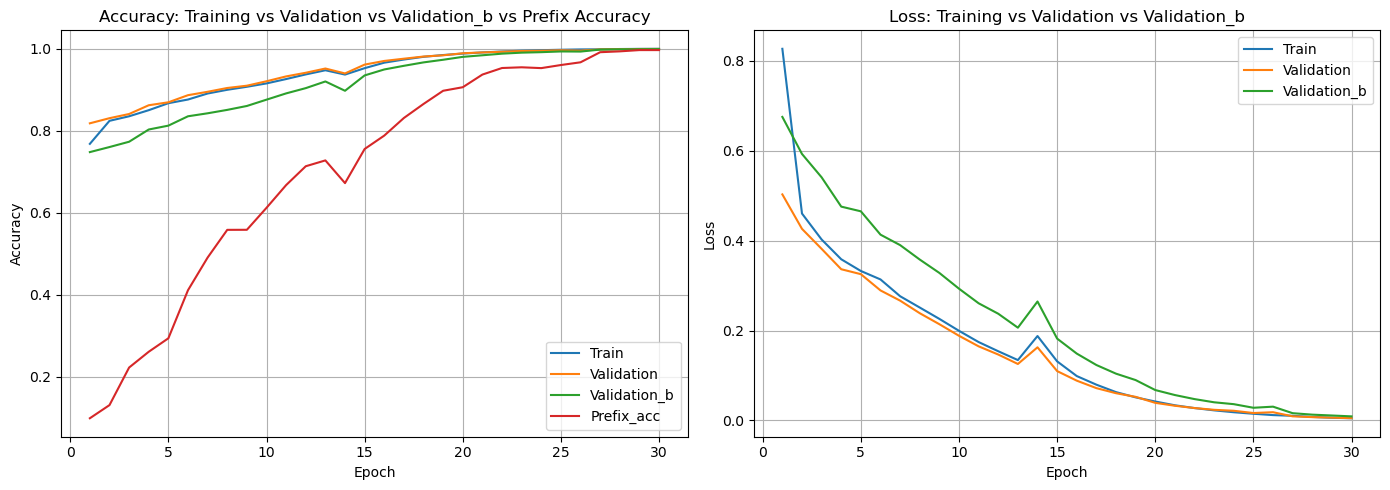

In [62]:
# 1) Estrai le curve di training/validation dal History
acc        = history.history['sparse_categorical_accuracy']
val_acc    = history.history['val_sparse_categorical_accuracy']
loss       = history.history['loss']
val_loss   = history.history['val_loss']
prefix_acc = prefix_cb.history
acc_val_b, loss_val_b = np.matrix(val_b.history)[:, 0], np.matrix(val_b.history)[:, 1]
epochs     = range(1, len(acc) + 1)

# Crea una figura con due subplot affiancati
fig1, axs = plt.subplots(1, 2, figsize=(14, 5))

# Subplot sinistro: Accuracy
axs[0].plot(epochs, acc, label='Train')
axs[0].plot(epochs, val_acc, label='Validation')
axs[0].plot(epochs, acc_val_b, label='Validation_b')
axs[0].plot(epochs, prefix_acc, label='Prefix_acc')
axs[0].set_title('Accuracy: Training vs Validation vs Validation_b vs Prefix Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')
axs[0].grid(True)

# Subplot destro: Loss
axs[1].plot(epochs, loss, label='Train')
axs[1].plot(epochs, val_loss, label='Validation')
axs[1].plot(epochs, loss_val_b, label='Validation_b')
axs[1].set_title('Loss: Training vs Validation vs Validation_b')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')
axs[1].grid(True)

plt.tight_layout()
plt.show()

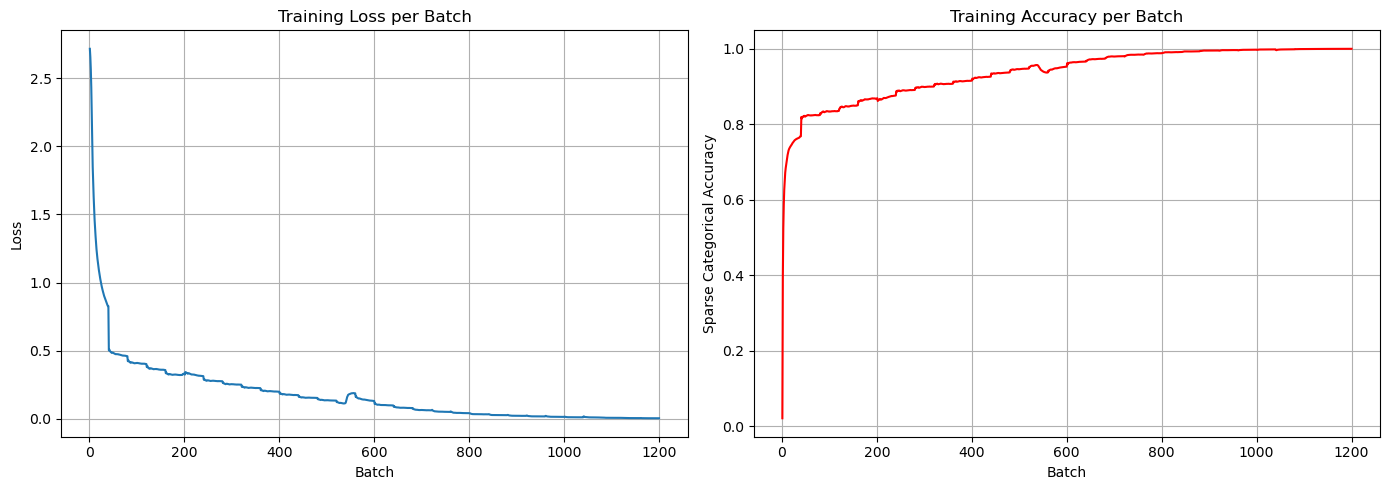

In [63]:
batches = range(1, len(batch_cb.batch_losses) + 1)
fig2, axs = plt.subplots(1, 2, figsize=(14, 5))

# Figura 1: Loss per batch
axs[0].plot(batches, batch_cb.batch_losses)
axs[0].set_title('Training Loss per Batch')
axs[0].set_xlabel('Batch')
axs[0].set_ylabel('Loss')
axs[0].grid(True)

# Figura 2: Accuracy per batch (rosso)
axs[1].plot(batches, batch_cb.batch_acc, color='red')
axs[1].set_title('Training Accuracy per Batch')
axs[1].set_xlabel('Batch')
axs[1].set_ylabel('Sparse Categorical Accuracy')
axs[1].grid(True)

plt.tight_layout()
plt.show()


## Conclusion

In [ ]:
hparams = {'embed_dim':EMBED_DIM, 'enc_units':ENC_UNITS, 'dec_units':DEC_UNITS, 'batch_size':BATCH_SIZE}
outputs = {'training': training_out.stdout, 'test': test_out.stdout, 'test_bonus': test_bonus_out.stdout}
figures = {'epoch': fig1, 'batch': fig2}
generate_report(hparams, outputs, figures, title = "v1")

In [ ]:
# model
seq2seq.summary()
seq2seq.save('progettoDL/report/model/seq2seq_attention_v0.h5')
seq2seq.save_weights('progettoDL/report/model/seq2seq_attention_v1.weights.h5')

Model: "seq2seq_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ enc_inputs          │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_inputs          │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_model       │ [(None, 30, 256), │    296,416 │ enc_inputs[0][0]  │
│ (Functional)        │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_model       │ [(None, 30, 15),  │    304,367 │ dec_inputs[0][0], │
│ (Functional)        │ (None, 256),      │            │ encoder_model[0]… │
│                     │ (None, 256)]      │            │ encoder_model[0]… │
│                     │                   │            │ encoder_model[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,802,351 (6.88 MB)

 Trainable params: 600,783 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,201,568 (4.58 MB)

---

In [ ]:
import  numpy as np
print("NumPy:", np.__version__)

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("tf:",tf.__version__)

import keras
print(keras.__version__)

NumPy: 2.0.2
[]
tf: 2.18.0
3.8.0


---
# Migliorie
- due dizionari separati
- mask accuracy/ uso di junk
- multi head or no head attention


---

### (B) “Perché non escluderle totalmente, se in output non vogliamo mai che il decoder le produca?”

Potenzialmente potremmo:

1. **Avere due vocabolari distinti**:

   * **Vocabolario input** = `{ '(', ')', '+', '-', '*', '/', 'a', 'b', 'c', 'd', 'e', PAD, SOS, EOS }`
   * **Vocabolario output** = `{ '+', '-', '*', '/', 'a', 'b', 'c', 'd', 'e', PAD, SOS, EOS, (forse JUNK) }`

   Durante l’encoding, usi il primo; in decoding, usi il secondo. In teoria è possibile, ma **comporta complessità aggiuntive**:

   * Devi convertire l’output logits (misure di confidenza “raw”) in due spazi diversi a seconda di encoder/decoder.
   * Se userai un’attenzione “di tipo dot” (che moltiplica `dec_output ⋅ enc_output^T`), vuoi che i due embedding (encoder e decoder) vivano nello **stesso spazio dimensionale** per calcolare i prodotti scalari. Mantenere due embedding completamente separate richiede di aggiungere proiezioni extra per riallineare gli spazi.


In [ ]:
def dedupe_dataset(data, max_depth=MAX_DEPTH, regenerate=False):

    idx_map = defaultdict(list)
    for idx, key in enumerate(data):
        idx_map[key].append(idx)    #for each string in data, keep track of all its indices
    counts = {key: len(idxs) for key, idxs in idx_map.items() if len(idxs) > 1} #for each duplicate string in data, keep track of hpw many duplicates there are
    duplicates = {key: idxs for key, idxs in idx_map.items() if len(idxs) > 1} #for each duplicate string in data, keep track of all its indices
    total = sum(counts.values()) 

    print(f"Found {len(duplicates)} duplicate string with totla counts: {total}")
    print(f"the percentage of duplicates is: {total / len(data) * 100}%")
    print("the top 10 duplicates are:")
    for key, idxs in sorted(counts.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {key} = {idxs}")
    # if regenerate:
    #     # 4) Per ogni chiave duplicata, rigenera nuovi esempi
    #     for key, idxs in duplicates.items():
    #         # mantieni la prima occorrenza, rigenera le altre
    #         for dup_idx in idxs[1:]:
    #             # calcola la lunghezza target (fino a EOS)
    #             seq = X[dup_idx]
    #             # EOS_ID è definito globalmente
    #             eos_pos = np.where(seq == EOS_ID)[0][0] + 1
    #             target_len = eos_pos  # numero di token inclusi EOS

    #             # rigenera fino a ottenere la stessa lunghezza
    #             while True:
    #                 # genera singolo esempio
    #                 x_new, y_new = generate_dataset(1, max_depth)
    #                 x_new = x_new[0]
    #                 y_new = y_new[0]
    #                 # trova eos nella nuova x
    #                 eos_new = np.where(x_new == EOS_ID)[0][0] + 1
    #                 if eos_new == target_len:
    #                     # accetta questa coppia
    #                     X[dup_idx] = x_new
    #                     Y[dup_idx] = y_new
    #                     break
        # dopo la rigenerazione, i duplicati originali sono stati sostituiti
        # ricostruisci le mappe se serve
        # (opzionale) si può riloggare quante rigenerazioni sono avvenute

    return duplicates, counts
